### 0. import libs

In [1]:
%run utils.ipynb

### 1. configs

In [2]:
image_dir = "./files/vehicle_models/"

### 2. load image

In [3]:
image_paths = get_all_images(image_dir, shuffle = True)

In [4]:
num = 12 # 11 12 13 14 15 16 17 18 100  # 19   13  14   15  16   17 18 19 119  689
image_path = image_paths[num]  

### 3. extract the ROI's y_upper 
- search region for the ROI's y_upper

In [5]:
alpha = 1.2
beta = 1.2
gamma = 0.8

(lp_x1, lp_y1, lp_x2, lp_y2), (lp_w, lp_h, lp_xc) = get_lp_coord(image_path)
roi_y2 = lp_y1


image = imread(image_path)

im_h, im_w = image.shape[:2]

# 从车牌左右两侧各伸展车牌宽度的alpha倍
sr_x1, sr_x2 = int(max(0, lp_x1 - alpha*lp_w)), int(min(im_w, lp_x2 + alpha*lp_w))
# 从车牌上沿分别延展车牌宽度的beta倍和gamma倍
sr_y1, sr_y2 = int(max(0, lp_y1 - beta*lp_w)), int(max(0, min(im_h, lp_y1 - gamma*lp_w)))
sr_w,  sr_h = sr_x2 - sr_x1, sr_y2 - sr_y1

- plot lp and search region

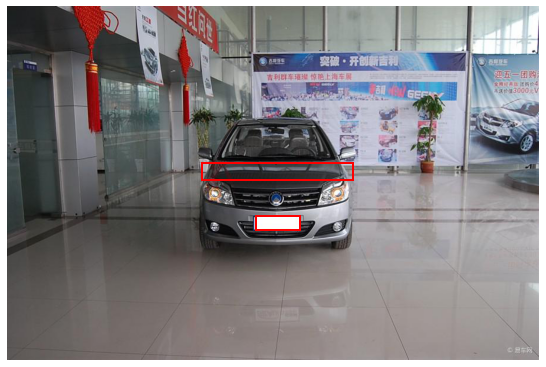

In [6]:
plt.figure(figsize=(16, 6.5))

# plt.title("search region of ROI's upper hood")
plt.imshow(image)
plt.gca().add_patch(plt.Rectangle(xy = (lp_x1, lp_y1), 
                                  width = lp_w, height = lp_h, edgecolor = 'red', fill = False, linewidth = 2))
plt.gca().add_patch(plt.Rectangle(xy = (sr_x1, sr_y1), 
                                  width = sr_w, height = sr_h, edgecolor = 'red', fill = False, linewidth = 2))

plt.plot()
plt.axis("off");

In [7]:
# 当车牌距离图片顶端很近时
# 当搜索区域的高度小于30时，roi的上边界等于搜索区域的下边界。
if sr_y2 - sr_y1 < 30:
    roi_y1 = sr_y2
    sr = 0
else:
    sr = image[sr_y1:sr_y2, sr_x1:sr_x2]

    # blur the image 
    sr_blur = cv2.GaussianBlur(sr, ksize=(5, 5), sigmaX=0, sigmaY=0)
    # sobel y
    sobel_sr_y = cv2.convertScaleAbs(cv2.Sobel(sr_blur, cv2.CV_16S, 0, 1, ksize = 3))

    # horizontal projection and normalize
    # 去除边缘图像左右两侧1/4的梯度信息，这部分信息可能包含车辆以外的梯度噪声，
    # 对挡风玻璃下沿的投影效果产生影响
    sobel_sr_y[:, :sobel_sr_y.shape[1]//4] = 0
    sobel_sr_y[:, sobel_sr_y.shape[1]//4*3:] = 0

    y_project = np.sum(sobel_sr_y, 1)
    y_project = y_project / np.max(y_project)
    y_project = mean_smooth(y_project, win_size = 10)

    # the roi_y1
    roi_y1 = np.argmax(y_project) + sr_y1 + 10

- plot soble y of sr and its y projection

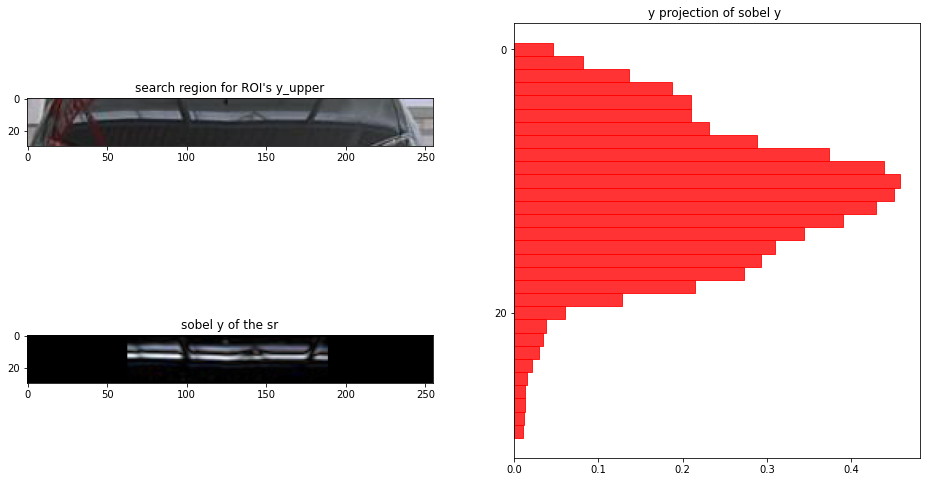

In [8]:
if isinstance(sr, np.ndarray):
    plt.figure(figsize=(16, 8))
    plt.gray()

    plt.subplot(221)
    plt.title("search region for ROI's y_upper")
    plt.imshow(sr)

    plt.subplot(223)
    plt.title("sobel y of the sr")
    plt.imshow(sobel_sr_y)

    plt.subplot(2,2,(2,4))
    plt.title("y projection of sobel y ")
    plt.barh(y = np.arange(y_project.shape[0], 0, -1), width = y_project, 
             color='red', height=1, alpha=0.8, edgecolor='red', );

    plt.yticks(range(y_project.shape[0], 0, -20), range(0, y_project.shape[0], 20));

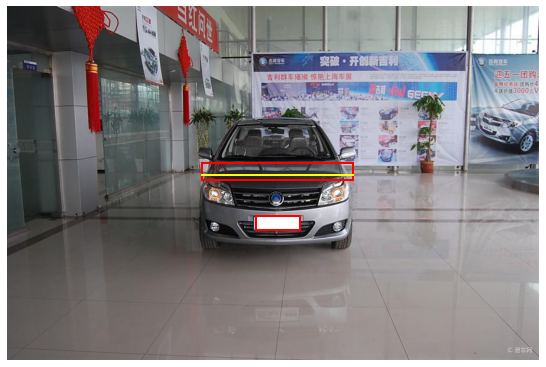

In [9]:
plt.figure(figsize=(16, 6.5))

# plt.title("search region of ROI's upper hood")
plt.imshow(image)
plt.gca().add_patch(plt.Rectangle(xy = (lp_x1, lp_y1), 
                                  width = lp_w, height = lp_h, edgecolor = 'red', fill = False, linewidth = 2))
plt.gca().add_patch(plt.Rectangle(xy = (sr_x1, sr_y1), 
                                  width = sr_w, height = sr_h, edgecolor = 'red', fill = False, linewidth = 2))

plt.plot((sr_x1, sr_x2), (roi_y1, roi_y1), color = "yellow", linewidth = 2)

plt.plot()
plt.axis("off");

### 4. extract the left and right bound of the ROI
- raw roi for the locating of the left and right side

In [10]:
kernel=np.array([[-1,0,1],
                  [-1,0,1],
                  [-1,0,1],])

alpha = 1.2
# 搜索区域的左右边界
x1, x2 = int(max(0, lp_x1 - alpha*lp_w)), int(min(im_w, lp_x2 + alpha*lp_w)) 
raw_roi_color = image[roi_y1 : roi_y2, x1 : x2]
raw_roi = cv2.cvtColor(image[roi_y1 : roi_y2, x1 : x2], cv2.COLOR_BGR2GRAY)

#     |       |           |           |        |               |         |      |
# 图片边界     x1     left_bound      lp_x1     lp_x2     right_bound    x2   图片边界
# 如果边界x1距离图像左边界大于10且x1据车牌左侧距离大于0.75个车牌宽度，则left_bound = 。

beta = 0.9
left_bound = int(lp_x1 - beta*lp_w) if int(lp_x1 - beta*lp_w) > 0  else 0
if left_bound - x1 < 10:
    roi_x1 = x1
else:
    left_region =  cv2.cvtColor(image[roi_y1:roi_y2, x1:left_bound], cv2.COLOR_BGR2GRAY)
    left_region_copy = left_region.copy()
    left_region[:left_region.shape[0]//5,:] = 0
    left_region = cv2.GaussianBlur(left_region, ksize=(15, 15), sigmaX=0, sigmaY=0)

    left_region = np.float32(left_region)
    left_region = cv2.filter2D(left_region, -1, kernel)
    left_region = cv2.convertScaleAbs(left_region) #
    left_region = cv2.threshold(left_region,11,1,cv2.THRESH_OTSU)[1]
    left_region = np.uint8(skeletonize(left_region)*255)
    left_region = cv2.blur(left_region, (1, 5)) #left_region = cv2.GaussianBlur(left_region, ksize=(15, 15), sigmaX=0, sigmaY=0)


    left_project = np.sum(left_region, 0)
    left_project = left_project / np.max(left_project)
    left_project = mean_smooth(left_project, win_size = 5)

    x_left = np.argmax(left_project) 
    roi_x1 = x_left + x1


right_bound = int(lp_x2 + beta*lp_w) if (im_w - lp_x2 + beta*lp_w) >0 else 0
if right_bound == 0 :
    roi_x2 = x2
else:

    right_region = cv2.cvtColor(image[roi_y1:roi_y2, right_bound: x2], cv2.COLOR_BGR2GRAY)
    right_region_copy = right_region.copy()
    right_region[:right_region.shape[0]//5,:] = 0
    right_region = cv2.GaussianBlur(right_region, ksize=(15, 15), sigmaX=0, sigmaY=0)

    right_region = np.float32(right_region)
    right_region = cv2.filter2D(right_region, -1, kernel)
    right_region = cv2.convertScaleAbs(right_region) 
    right_region = cv2.threshold(right_region,11,1,cv2.THRESH_OTSU)[1]
    right_region = np.uint8(skeletonize(right_region)*255)
    right_region = cv2.blur(right_region, (1, 5))#cv2.GaussianBlur(right_region, ksize=(15, 3), sigmaX=0, sigmaY=0)

    right_project = np.sum(right_region, 0)
    right_project = right_project /np.max(right_project)
    right_project = mean_smooth(right_project, win_size = 5)

    x_right = np.argmax(right_project) #+ 10
    roi_x2 = x_right + right_bound



dist = min(roi_x2 - lp_xc, lp_xc - roi_x1)
roi_x1, roi_x2 = lp_xc - dist, lp_xc + dist

<Figure size 432x288 with 0 Axes>

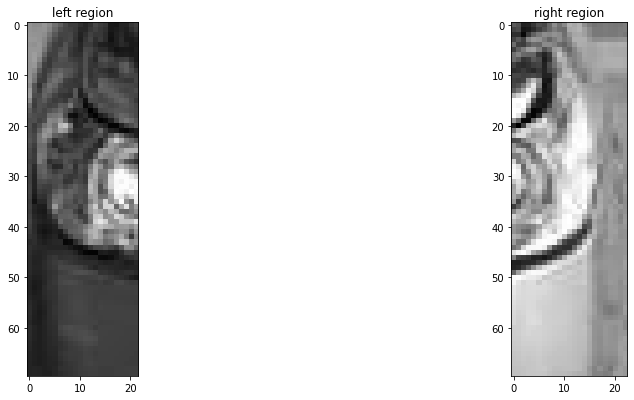

In [11]:
plt.gray()
plt.figure(figsize=(16, 6.5))
plt.subplot(1,2,1)
plt.imshow(left_region_copy)
plt.title("left region")

plt.subplot(1,2,2)
plt.imshow(right_region_copy)
plt.title("right region")
plt.plot();
# plt.axis("off");

<Figure size 432x288 with 0 Axes>

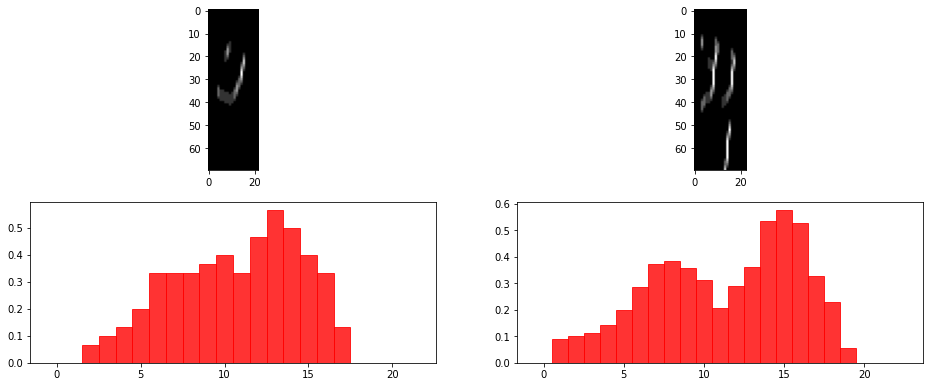

In [12]:
plt.gray()
plt.figure(figsize=(16, 6.5))
plt.subplot(2,2,1)
plt.imshow(left_region)

plt.subplot(2,2,3)
plt.bar(x = np.arange(left_project.shape[0]), height = left_project, 
         color='red', width=1, alpha=0.8, edgecolor='red', );

plt.subplot(2,2,2)
plt.imshow(right_region)

plt.subplot(2,2,4)
plt.bar(x = np.arange(right_project.shape[0]), height = right_project, 
         color='red', width=1, alpha=0.8, edgecolor='red', );


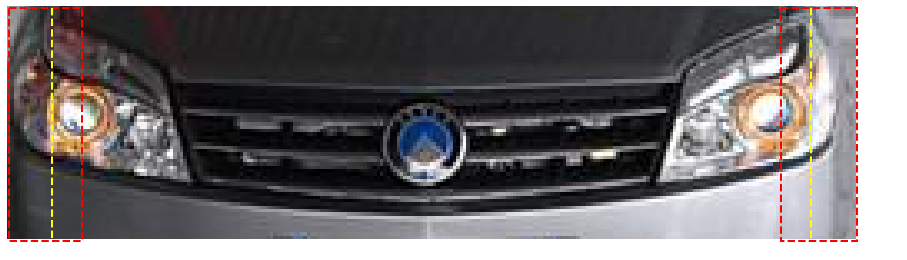

In [13]:
plt.figure(figsize=(16, 6.5))
plt.imshow(raw_roi_color)
# plt.title("ROI")
# left search region
plt.gca().add_patch(plt.Rectangle(xy = (0, 0), 
                                  width = left_bound - x1, height = raw_roi.shape[0], 
                                  edgecolor = 'red', fill = False, linewidth = 2, linestyle = "--"))
# right search region
plt.gca().add_patch(plt.Rectangle(xy = (right_bound - x1, 0), 
                                  width = x2 - right_bound, height = raw_roi.shape[0], 
                                  edgecolor = 'red', fill = False, linewidth = 2, linestyle = "--"))

plt.plot((roi_x1 - x1, roi_x1 - x1), (0, raw_roi.shape[0]), color = 'yellow', linewidth = 2, linestyle = "--")
plt.plot((roi_x2 - x1, roi_x2 - x1), (0, raw_roi.shape[0]), color = 'yellow', linewidth = 2, linestyle = "--")


plt.plot();
plt.axis("off");

In [14]:
_, [roi_x11, roi_y11, roi_x12, roi_y12], _ = roi_extraction_1(image_path)
_, [roi_x21, roi_y21, roi_x22, roi_y22], _ = roi_extraction_2(image_path)

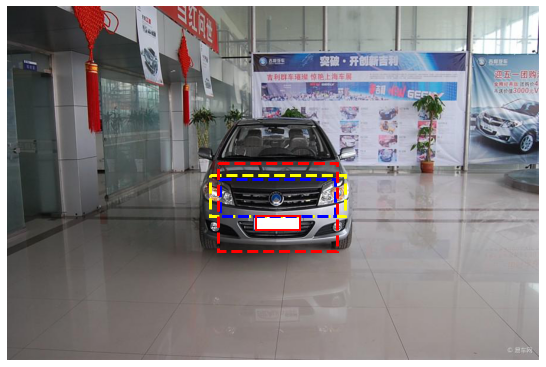

In [15]:
plt.figure(figsize=(16, 6.5))
plt.imshow(image)
# plt.title("ROI in image")
# final roi
plt.gca().add_patch(plt.Rectangle(xy = (roi_x1, roi_y1), 
                                  width = roi_x2 - roi_x1, height = roi_y2 - roi_y1, 
                                  edgecolor = 'yellow', fill = False, linewidth = 3, linestyle = "--"))

plt.gca().add_patch(plt.Rectangle(xy = (roi_x11, roi_y11), 
                                  width = roi_x12 - roi_x11, height = roi_y12 - roi_y11, 
                                  edgecolor = 'blue', fill = False, linewidth = 3, linestyle = "--"))

plt.gca().add_patch(plt.Rectangle(xy = (roi_x21, roi_y21), 
                                  width = roi_x22 - roi_x21, height = roi_y22 - roi_y21, 
                                  edgecolor = 'red', fill = False, linewidth = 3, linestyle = "--"))

# lp
plt.gca().add_patch(plt.Rectangle(xy = (lp_x1, lp_y1), 
                                  width = lp_w, height = lp_h, edgecolor = 'red', fill = False, linewidth = 2))

plt.plot();
plt.axis("off");